#                                          TASK : CUSTOMER SEGMENTATION USING RFM ANALYSIS

## IMPORTING THE CSV FILE

In [2]:
import pandas as pd
df = pd.read_csv("Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-10 8:26,3.39,17850.0,United Kingdom


## CLEANING THE CSV FILE FOR BETTER ANALYSIS

### Step 1: Drop Missing Values

In [3]:
df = df.dropna(subset=['CustomerID'])

### Step 2: Remove cancellations

In [4]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

### Step 3: Keep only positive quantities & prices

In [5]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

### Step 4: Create a Total Sales column

In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-10 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-10 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-10 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-10 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-10 8:26,3.39,17850.0,United Kingdom,20.34


### Step 5: Fix Date Column

In [18]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H:%M')


In [19]:
print(df['InvoiceDate'].head())
print(df['InvoiceDate'].dtype)   


0   2010-01-12 08:26:00
1   2010-01-12 08:26:00
2   2010-01-12 08:26:00
3   2010-01-12 08:26:00
4   2010-01-12 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]
datetime64[ns]


## RFM SCORING AND GROUPING SIMILAR CUSTOMERS

### Step 1: Prepare RFM Table

In [20]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,327,1,77183.60
1,12347.0,41,7,4310.00
2,12348.0,77,4,1797.24
3,12349.0,20,1,1757.55
4,12350.0,312,1,334.40


### Step 2: Assign Scores (1–5)

In [21]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Frequency score (higher = better)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Monetary score (higher = better)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

### Step 3: Combine into RFM Segment & Score

In [22]:
# Combine scores
rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm['R_Score'].astype(int) +
    rfm['F_Score'].astype(int) +
    rfm['M_Score'].astype(int)
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,327,1,77183.60,1,1,5,115,7
1,12347.0,41,7,4310.00,4,5,5,455,14
2,12348.0,77,4,1797.24,3,4,4,344,11
3,12349.0,20,1,1757.55,4,1,4,414,9
4,12350.0,312,1,334.40,1,1,2,112,4


### Step 4: Classifying Customers into Groups

In [23]:
def segment_customer(score):
    if score >= 12:
        return 'Top Customers'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Customers'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

rfm['Segment'].value_counts()

Segment
Top Customers          1278
Potential Customers    1144
Loyal Customers        1017
At Risk                 899
Name: count, dtype: int64

## 🎯 Simple Marketing Ideas For Each Group

##### Top Customers → Treat them like VIPs. Give early access, special rewards, and thank-you perks.

##### Loyal Customers → Keep them happy with discounts, loyalty points, and product suggestions.

##### Potential Customers → Encourage them with limited-time offers and personalized deals.

##### At Risk → Win them back with “We miss you” messages, special coupons, or small freebies.

# BONUS TASK: VISUALIZE RFM SEGMENTS WITH HEATMAPS OR BAR CHART

## BAR CHART

C:\Users\kk\AppData\Local\Temp\ipykernel_11244\276800038.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm,


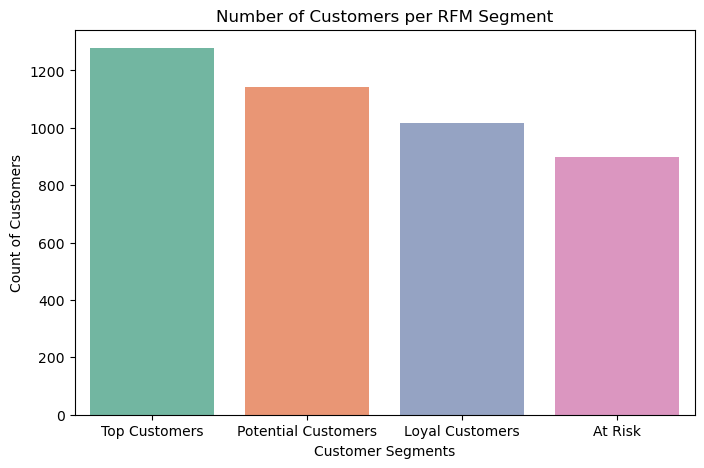

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, 
              order=rfm['Segment'].value_counts().index, 
              palette="Set2")

plt.title("Number of Customers per RFM Segment")
plt.xlabel("Customer Segments")
plt.ylabel("Count of Customers")
plt.show()

## HEATMAP

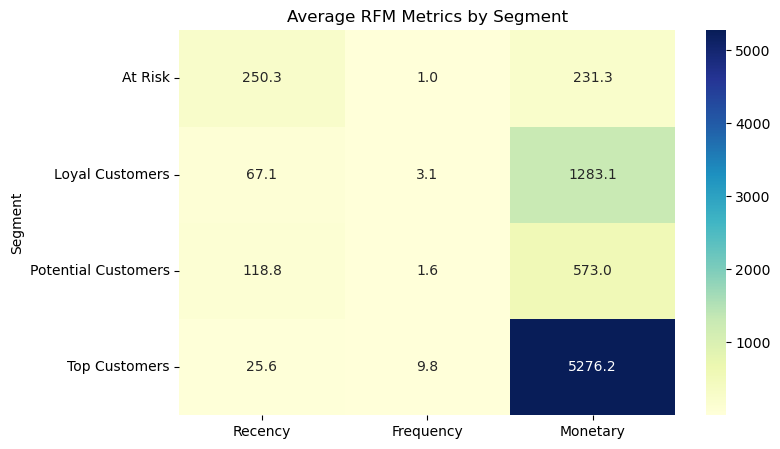

In [31]:
# Group by Segment and calculate mean only for numeric columns
rfm_summary = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()

plt.figure(figsize=(8,5))
sns.heatmap(rfm_summary, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM Metrics by Segment")
plt.show()


# SUMMARY 

#### We took the sales dataset and cleaned it by removing missing CustomerID, cancellations, and negative values, then created a TotalPrice column. Using this, we performed RFM analysis by calculating Recency (days since last purchase), Frequency (number of purchases), and Monetary (total spend) for each customer. We then assigned RFM scores (1–5) and combined them into an overall RFM Score, segmenting customers into groups like Top Customers, Loyal Customers, Potential Customers, and At Risk. Finally, we visualized these groups with bar charts and heatmaps to clearly understand customer behavior.